# Recognizing Handwritten Digits of the MNIST Datset Using a Neural Network

## Contents

1. Business Goal <br/><br/>

2. Imports <br/><br/>

3. Introducing the Dataset <br/><br/>

4. Implementing an SVM Base Model <br/><br/>

5. Building a 'simple' Feed-Forward Neural Network for Digit Recognition  
    * The Architecture: Size and Sequence of Layers
<br/><br/> 
    * The Different Layers and their Activation Functions
<br/><br/>
    * Compiling: Optimizer, Loss Function, Metrics  
<br/><br/>
6. Evaluating our Feed-Forward Nural Network Model
    * Validation Accuracy
<br/><br/>
    * The Learning Curve
<br/><br/>
7. Building an Advanced CNN Model
    * The Architecture: Size and Sequence of Layers
<br/><br/>
    * The Different Layers and their Activation Functions
<br/><br/>
    * Compiling: Optimizer, Loss Function, Metrics
<br/><br/>
8. Evaluating our CNN Model
<br/><br/>
9. Conclusion


## 1. Business Goal

Implementing a neural network to recognize handwritten digits with the highest possible precision.

A use case could be to implement the solution a sorting machine in a post office to sort handwritten postal codes. 

Numbers for reference: the new DHL logistic centre in Bochum is processing up to 50000 parcels per hour. On peak days 11 million per day. Not all of which are handwritten. However, by improving the accuracy by 0.1% we could petentially save the DHL center in Bochum 4380 Euros a year in costs. This is assuming that 10% of th letters are handwritten and sorting a letter manually costs 10 cents. The impact could be still further amplified if DHL uses our image recognition in more logistics centers.

## 2. Imports

In [62]:
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import tensorflow.keras as keras
from keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPool2D, Conv2D, Flatten 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


# To get this running you need to pip install pydot and install graphviz (not a pip installation)
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

## 3.  Introducing the Dataset
The MNIST database of handwritten digits labeled, available as packaged data in Tensorflow, has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

In [49]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

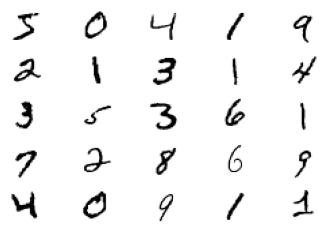

In [4]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i], cmap=plt.cm.Greys)
    plt.axis('off')

## 4. Implementing SVM as Base Model
We are building this model as a base model to quickly get an impression of the accuracy that can be achieved with comparatively little effort by conventional mehtods. Later we will compare our results of this model to the results of the neural network.

In [50]:
# Change from matrix to array --> dimension 28x28 to array of dimention 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [51]:
# Change to float datatype
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [52]:
# Scale the data to lie between -1 to 1
X_train = X_train / 255.0*100 - 50
X_test = X_test / 255.0*100 - 50
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [8]:
# PCA
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

###  GRID SEARCH FOR PARAMETER OPTIMIZING

In [9]:
svm = SVC()
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
print("grid search")
grid = GridSearchCV(svm, parameters, verbose=3)
print("grid.fit")
grid.fit(X_train[0:1000], y_train[0:1000]) #grid search learning the best parameters
print("grid done")

print (grid.best_params_)

grid search
grid.fit
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.2s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.2s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.2s
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.150 total time=   0.2s
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.150 total time=   0.2s
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.175 total time=   0.2s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.135 total time=   0.2s
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.170 total time=   0.2s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.2s
[CV 2/5] END .....C=10, gamm

In [10]:
# Now we train the best estimator in the full dataset
print("training svm")
best_svm = grid.best_estimator_
best_svm.fit(X_train[0:20000] , y_train[0:20000])
print("svm done")


print("Testing")
print("score: ", best_svm.score(X_test[0:5000], y_test[0:5000],))

training svm
svm done
Testing
score:  0.2358


Now that we have our base model, we can start making a neural network that we can compare it, too.

## Basel Model Validation Accuracy: 23.5%

## 5. Building a 'Simple' Feed-Forward Neural Network for Digit Recognition

We start by performin a train test split.

In [53]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Neural networks can only work with 2-dimensional inputs. Therefore we are flattening the in put by multiplying the two pixel dimensions.

### Reshape the data

In [55]:
# Change from matrix to array --> dimension 28x28 to array of dimention 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

We need all values to be floats.

In [56]:
# Change to float datatype
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

The model works better when all values are normalized.

In [57]:
# Scale the data to lie between -1 to 1
X_train = X_train / 256
X_test = X_test / 256
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [17]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
X_train.shape

(60000, 784)

In [19]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

### The Architecture
We are choosing a funnel-like architecture for our neural network. This means that we are choosing a big dense layer followed by small dense layer followed by small output layer. This type of architecture is commonly chosen for image recognition. For example the popular VGG-16, a pretrained network, has the folowing architecture:

![funnel](funnel.jpg)

### The Different Layers and their Activation Functions
In our Feed-Forward Neural Network we will only 3 Layers. Beween the layers we are adding Batch-Normalization-Layers and Dropout-Layers to prevent overfitting and improve the robustness of our model. 
It is necessary to the softmax activation function in the output layer because we are dealing with a multi-class classification problem. In this case we are also using it in the other layers because it yielded the best results. However this function is known to be more computationally expensive than for example the 'relu' activation function. Since we are initially building a comparatively small model with about 66000 prameters, this will not be a problem.

In [20]:
# clearing the session to avoid interference by chached models
K.clear_session()

m = Sequential([
    Dense(units=79, activation='softmax', input_shape=(784,)), # Hidden layer
    # units: The number of neurons
    # activation: The activation function used in each neuron
    # input_shape: The input shape of the data
    BatchNormalization(),
    Dropout(0.2),
    Dense(units=40, activation='softmax'),
    BatchNormalization(),
    Dropout(0.5),# Hidden layer
    Dense(units=10, activation='softmax') # Output layer
    # Notice that in the case of the output layer the activation function is determined by the problem
    # we are tackling; in our case we have a binary classification problem which suggests to use 
    # the sigmoid activation function
    
])

In [21]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 79)                62015     
_________________________________________________________________
batch_normalization (BatchNo (None, 79)                316       
_________________________________________________________________
dropout (Dropout)            (None, 79)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                4

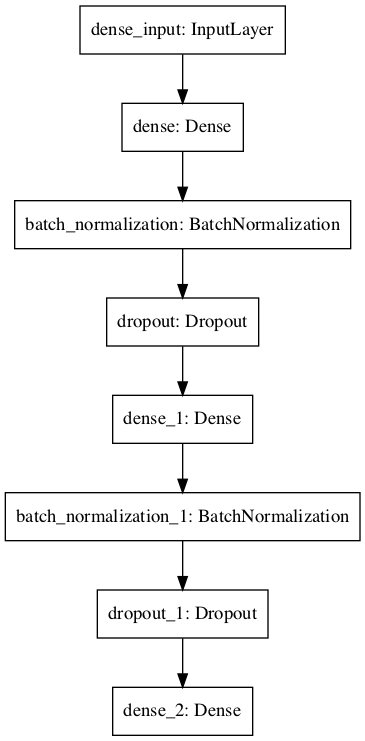

In [22]:
# graphically display the neural network
plot_model(m,
   #to_file='model.png',
   show_shapes=False,
   show_layer_names=True,
   rankdir='TB', expand_nested=False, dpi=96
)

### Compiling: Optimizer, Loss Function, Metrics
Before we can fit the model, we need to complile it. In this step we choose important parameters of the model:

The Optimization Function
We are choosing 'ADAM' (adaptive moment estimation), which is which is computatioally efficient and has little memory requirements. It possesses an daptive learning rate, interpretes the gradient as acceleration and thus usually converges faster. It oscillates around the minimum, which means there is the possibility that it doesn't find the optimum values. We would deal with that in case this becomes appearant.

The Loss Function
For a multi-class classification in a sparse matrix (only a small number of fields filled in our table), as in our case, we would have to use the sparse-categorical-crossentropy function. Also known as sparse categorical log-loss function.

The Metrics 
We want to know how high our accuracy gets. Which means how many digits of 100 would be recognized correctly. 

In [27]:
#compiling the model 
m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [28]:
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)
history = m.fit(X_train, y_train, batch_size=120, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
400/400 [==============================] - 4s 6ms/step - loss: 0.0873 - accuracy: 0.9755 - val_loss: 0.1056 - val_accuracy: 0.9743
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0829 - accuracy: 0.9764 - val_loss: 0.1119 - val_accuracy: 0.9728
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0835 - accuracy: 0.9760 - val_loss: 0.1076 - val_accuracy: 0.9733
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.0788 - accuracy: 0.9783 - val_loss: 0.1103 - val_accuracy: 0.9733


## 3. Evaluating our Model

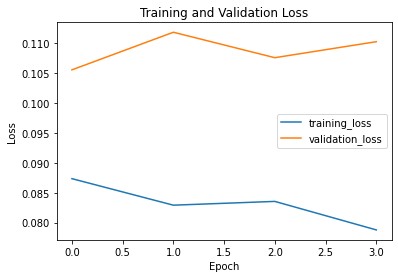

In [29]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

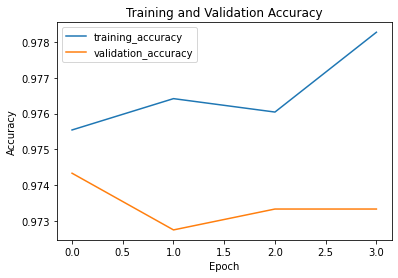

In [30]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [32]:
m.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1044 - accuracy: 0.9738


[0.10439304262399673, 0.973800003528595]

PREDICTION: 3


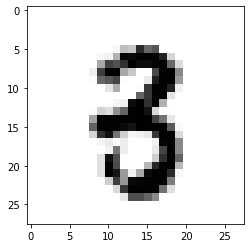

In [45]:
# getting an image and checking the prediction 
image_index = 2853
plt.imshow(X_test[image_index].reshape(28, 28),cmap='Greys')
predict = X_test[image_index].reshape(28,28)
pred = m.predict(X_test[image_index].reshape(1,784))
print('PREDICTION:', pred.argmax())

# 4.  Building an Advanced CNN Model

### The Architecture: Size and Sequence of Layers

CNNs are biologically-inspired models inspired by research by D. H. Hubel and T. N. Wiesel. They proposed an explanation for the way in which mammals visually perceive the world around them using a layered architecture of neurons in the brain, and this in turn inspired engineers to attempt to develop similar pattern recognition mechanisms in computer vision.

Thus deep convolutional neural networks (CNN) are designed with the following elements, which were inspired by nature:
- local connections 
- layering  
- spatial invariance (shifting the input signal results in an equally shifted output signal. , most of us are able to recognize specific faces under a variety of conditions because we learn abstraction These abstractions are thus invariant to size, contrast, rotation, orientation
 
The following computational mechanisms occur in CNN's:
- convolution operation
- shared weights
- pooling/subsampling 

However, it's not proven that these are the same mechanisms occurring in the primate visual system.

![CNN](CNN.png)

Illustration of the CNN model achitecture by [mathworks](https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1497876372993.jpg 'go to page')


### Loading and Preparing the Data

In [104]:
# loading the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#make the input 4 dimensional

X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))


# scale the output to range 0,1
X_train = X_train_reshaped.astype('float32') / 255
X_test = X_test_reshaped.astype('float32') / 255


y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

### The Different Layers and their Activation Functions

In [124]:
K.clear_session()
model = Sequential()
# first convolutional block
# adds a convolutional layer with 64 units and a 3x3 kernel
# add a MaxPooling2D layer with a pool size of 2x2
model.add(Conv2D(filters=28,
                            padding='same',
                            activation ='relu',
                            kernel_size=(3,3),
                            input_shape=(28, 28, 1) # rows, cols, color channels
                            ))

model.add(MaxPool2D(pool_size=(2, 2)))


#final dense block
#add a layer that flattens the output
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#add a dense output layer with 10 units and softmax activation
model.add(Dense(10, activation='softmax'))




In [125]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 28)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5488)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               702592    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 704,162
Trainable params: 704,162
Non-trainable params: 0
__________________________________________________

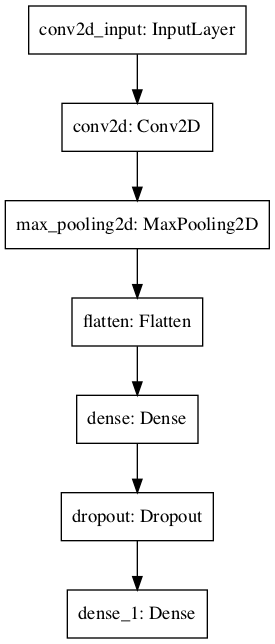

In [126]:
plot_model(model,
   #to_file='model.png',
   show_shapes=False,
   show_layer_names=True,
   rankdir='TB', expand_nested=False, dpi=96
)

### Compiling: Optimizer, Loss Function, Metrics

In [127]:
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
results = model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.3)

Epoch 1/10
210/210 [==============================] - 20s 91ms/step - loss: 2.1309 - accuracy: 0.2817 - val_loss: 1.5925 - val_accuracy: 0.6086
Epoch 2/10
210/210 [==============================] - 18s 87ms/step - loss: 1.2140 - accuracy: 0.6272 - val_loss: 0.7278 - val_accuracy: 0.8277
Epoch 3/10
210/210 [==============================] - 18s 87ms/step - loss: 0.8152 - accuracy: 0.7469 - val_loss: 0.5124 - val_accuracy: 0.8672
Epoch 4/10
210/210 [==============================] - 19s 92ms/step - loss: 0.6690 - accuracy: 0.7969 - val_loss: 0.4328 - val_accuracy: 0.8845
Epoch 5/10
210/210 [==============================] - 21s 99ms/step - loss: 0.5941 - accuracy: 0.8159 - val_loss: 0.3916 - val_accuracy: 0.8912
Epoch 6/10
210/210 [==============================] - 21s 101ms/step - loss: 0.5498 - accuracy: 0.8342 - val_loss: 0.3569 - val_accuracy: 0.8967
Epoch 7/10
210/210 [==============================] - 19s 90ms/step - loss: 0.5200 - accuracy: 0.8427 - val_loss: 0.3302 - val_accuracy

In [12]:
# calculate the accuracy 
results.history['val_accuracy']

[0.8510000109672546,
 0.9549999833106995,
 0.9779999852180481,
 0.9649999737739563,
 0.9789999723434448]

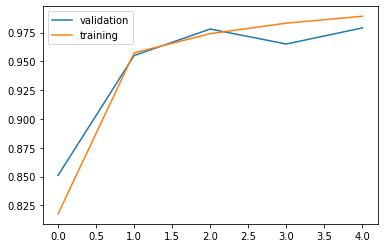

In [13]:
#plot a curve of the training and validation loss
plt.plot(results.history['val_accuracy'], label='validation')
plt.plot(results.history['accuracy'], label='training')
plt.legend()

In [14]:
y_pred = model.evaluate(X_test_reshaped, y_test_reshaped)

313/313 [==============================] - 10s 31ms/step - loss: 0.0306 - accuracy: 0.9891
